In [266]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [15, 15] #figure size
plt.rcParams.update({'font.size': 22}) # caption siz

In [267]:
def gaussian(x, mean, variance):
    return np.exp(-np.square(x-mean)/(2.0*np.square(variance)))

def square_function(x):
    sin_x = np.sin(x)
    return np.array([1.0 if val >= 0.0 else -1.0 for val in sin_x])

def absolute_residual_error(predicted, expected):
    return np.mean(np.absolute(predicted - expected))

In [268]:
class rbf_network:
    def __init__(self):
        self.weights = None
        self.centers = None
        self.gaussian = np.vectorize(gaussian)

    def fit(self, patterns, targets, centers=None, variance=None, center_count=0, epochs=200, cl_epochs=1000,
            learning_rate=0.07, centers_learning_rate=0.2, learning_rule="least_squares"):
        #transpose column vector to row vector
        patterns = patterns.T
        targets = targets.T

        self.centers = centers
        self.variance = variance

        if learning_rule == "cl":
            self.init_centers(center_count)
            for _i in range(cl_epochs):
                curr_pattern = np.random.choice(patterns[:, 0])
                nearest_center_ind = np.argmin(np.linalg.norm(self.centers-curr_pattern, axis=1))
                update_vector = centers_learning_rate*(curr_pattern - self.centers[nearest_center_ind])
                self.centers[nearest_center_ind] = self.centers[nearest_center_ind] + update_vector

        if learning_rule == "least_squares":
            phi = self.gaussian(patterns, self.centers, self.variance)
            self.weights = np.linalg.inv(phi.T @ phi) @ phi.T @ targets

        elif learning_rule == "delta" or learning_rule=="cl":
            self.init_weights(self.centers.shape[0], 1, patterns.shape[0])
            for _i in range(epochs):
                shuffled_idxs = np.random.permutation(patterns.shape[0])
                for idx in shuffled_idxs:
                    curr_pattern, curr_target = patterns[idx], targets[idx]
                    phi = gaussian(curr_pattern, self.centers, self.variance)
                    delta_w = (curr_target - phi.T @ self.weights) * phi
                    self.weights += learning_rate * delta_w
        return self.centers

    #input is a column vector
    def predict(self, patterns):
        phi = self.gaussian(patterns, self.centers, self.variance).T
        return phi @ self.weights

    def init_weights(self, pattern_dim, target_dim, pattern_count):
        self.weights = np.random.normal(loc=0.0, scale=1.0/pattern_count, size=(pattern_dim, target_dim))

    def init_centers(self, center_count):
        self.centers = np.random.uniform(low=INTERVAL_START, high=INTERVAL_END, size=center_count)
        self.centers = self.centers.reshape(len(self.centers), 1)

In [269]:
INTERVAL_START = -np.pi/4.0
INTERVAL_END = 2*np.pi
INTERVAL_STEP = np.pi/2.0

# Estimating noisy sin(2x)

In [271]:
train_inputs = np.arange(0, 2*np.pi, 0.1)
train_inputs = np.reshape(train_inputs, (1, train_inputs.shape[0]))
train_outputs = np.sin(2*train_inputs)
train_outputs_noisy =train_outputs + np.random.normal(0, 0.1, train_outputs.shape)

test_inputs = np.arange(0.05, 2*np.pi, 0.1)
test_inputs = np.reshape(test_inputs, (1, test_inputs.shape[0]))
test_outputs = np.sin(2*test_inputs)
test_outputs_noisy = test_outputs + np.random.normal(0, 0.1, test_outputs.shape)

In [272]:
rbf_nn = rbf_network()

In [273]:
variance = np.pi/8.0

adjusted_centers1 = rbf_nn.fit(train_inputs, train_outputs, variance=variance, learning_rule="cl", center_count=6)
results_original = rbf_nn.predict(test_inputs)
absolute_residual_error(results_original, test_outputs)

0.7708731560672876

In [42]:
variance = np.pi/8.0

adjusted_centers2 = rbf_nn.fit(train_inputs, train_outputs_noisy, variance=variance, learning_rule="cl", center_count=6)
results_noisy = rbf_nn.predict(test_inputs)
absolute_residual_error(results_noisy, test_outputs_noisy)

0.7934686517008258

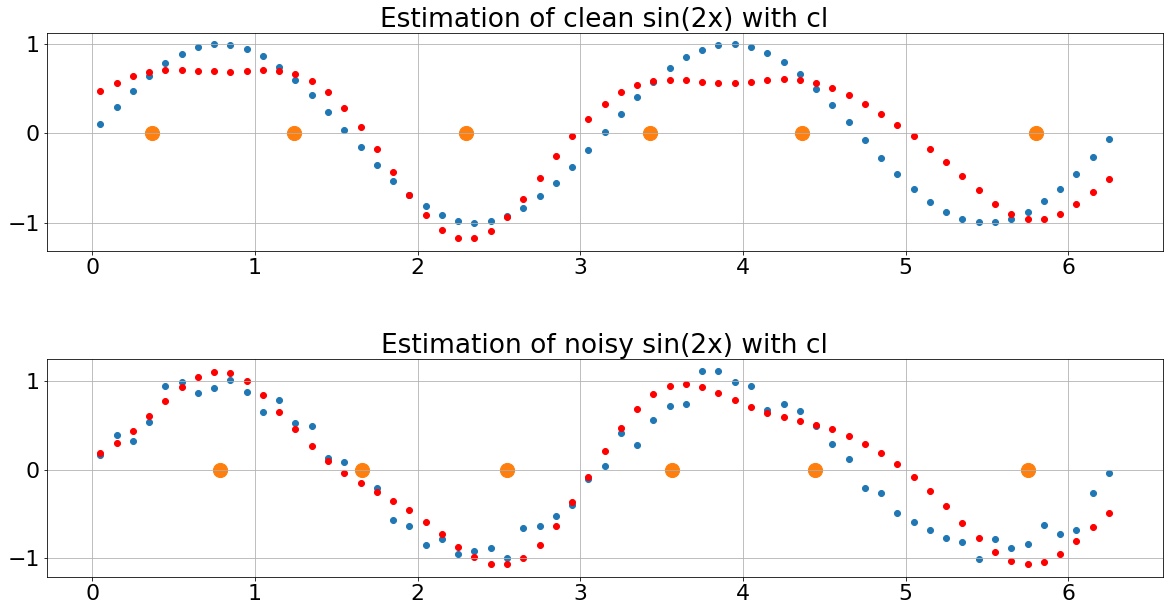

In [43]:
plt.rcParams['figure.figsize'] = [20, 10] #figure size

fig, axs = plt.subplots(2)
axs[0].set_title("Estimation of clean sin(2x) with cl")
axs[0].scatter(test_inputs, test_outputs)
axs[0].scatter(test_inputs, results_original, c='r')
axs[0].scatter(adjusted_centers1, np.zeros(len(adjusted_centers1)), s=200)
axs[0].grid()

axs[1].set_title("Estimation of noisy sin(2x) with cl")
axs[1].scatter(test_inputs, test_outputs_noisy, label="True value(with noise)")
axs[1].scatter(test_inputs, results_noisy, c='r', label="Approximation")
axs[1].scatter(adjusted_centers2, np.zeros(len(adjusted_centers2)), s=200, label="Centroids")
axs[1].grid()

plt.subplots_adjust(hspace = 0.5)
plt.show()

Since the training samples are uniformly distributed, the centroids cannot estimate any clusters. They will be close to distributed uniformly as well, which is better than random, but worse than placing them by hand. The predicative performance is also worse than picking them manually. 

Dead units can be avoided by updating more than a single node, in proportion of the distance from the winner node. The distance function can be a gaussian. Or relocalizing a node if it haven't won any of the last hundred iterations.

# The ballistic dataset

In [274]:
def gaussian_2d(x, mean, variance):
    return np.exp(-np.sum(np.square(x-mean), axis=1)/(2.0*np.square(variance)))

In [275]:
class rbf_network_with_cl:
    def __init__(self):
        self.weights = None
        self.centers = None

    def fit(self, patterns, targets, centers=None, variance=None, center_count=0, epochs=500, cl_epochs=1000,
            learning_rate=0.01, centers_learning_rate=0.2):

        self.centers = centers
        self.variance = variance

        self.init_centers(center_count, patterns.shape[1])
        for _i in range(cl_epochs):
            curr_pattern_idx = np.random.choice(range(patterns.shape[0]))
            curr_pattern = patterns[curr_pattern_idx]
            nearest_center_ind = np.argmin(np.linalg.norm(self.centers-curr_pattern, axis=1))
            update_vector = centers_learning_rate*(curr_pattern - self.centers[nearest_center_ind])
            self.centers[nearest_center_ind] += update_vector

        self.init_weights(self.centers.shape[0], targets.shape[1], patterns.shape[0])
        for _i in range(epochs):
            shuffled_idxs = np.random.permutation(patterns.shape[0])
            for idx in shuffled_idxs:
                curr_pattern, curr_target = patterns[idx], targets[idx]
                phi = gaussian_2d(curr_pattern, self.centers, self.variance)
                phi = np.reshape(phi, (phi.shape[0], 1))

                #this is a little different than the formula in the assingment
                #description, but it does the same thing, and the dimensions are matching
                delta_w = phi @ (curr_target - phi.T @ self.weights)
                self.weights += learning_rate * delta_w

        return self.centers

    #input is a column vector
    def predict(self, patterns):
        phi = np.array([gaussian_2d(x, self.centers, self.variance) for x in patterns])
        return phi @ self.weights

    def init_weights(self, center_count, target_dim, pattern_count):
        self.weights = np.random.normal(loc=0.0, scale=1.0/pattern_count, size=(center_count, target_dim))

    def init_centers(self, center_count, pattern_dims):
        #the interval is hardcoded here
        self.centers = np.random.uniform(low=0.0, high=1.0, size=(center_count,pattern_dims))



In [276]:
ballist_data = np.loadtxt('ballist.dat')
train_inputs = ballist_data[:, 0:2]
train_outputs = ballist_data[:, 2:]

ballist_test_data = np.loadtxt('balltest.dat')
test_inputs = ballist_test_data[:, 0:2]
test_outputs = ballist_test_data[:, 2:]

In [278]:
rbf_nn_cl = rbf_network_with_cl()

In [279]:
variance = 0.5
adjusted_not_enough_centers = rbf_nn_cl.fit(train_inputs, train_outputs, variance=variance, center_count=4)
results_train_not_enough = rbf_nn_cl.predict(train_inputs)
results_test_not_enough = rbf_nn_cl.predict(test_inputs)
absolute_residual_error(results_train_not_enough, train_outputs), absolute_residual_error(results_test_not_enough, test_outputs)

(0.07413338342622794, 0.08001715657996598)

In [280]:
variance = 0.3
adjusted_enough_centers = rbf_nn_cl.fit(train_inputs, train_outputs, variance=variance, center_count=10)
results_train_enough = rbf_nn_cl.predict(train_inputs)
results_test_enough = rbf_nn_cl.predict(test_inputs)
absolute_residual_error(results_train_enough, train_outputs), absolute_residual_error(results_test_enough, test_outputs)

(0.02622296608171807, 0.03426000536102484)

In [281]:
variance = 0.2
adjusted_too_much_centers = rbf_nn_cl.fit(train_inputs, train_outputs, variance=variance, center_count=50)
results_train_too_much = rbf_nn_cl.predict(train_inputs)
results_test_too_much = rbf_nn_cl.predict(test_inputs)
absolute_residual_error(results_train_too_much, train_outputs), absolute_residual_error(results_test_too_much, test_outputs)

(0.010752839709343797, 0.01513398776889881)

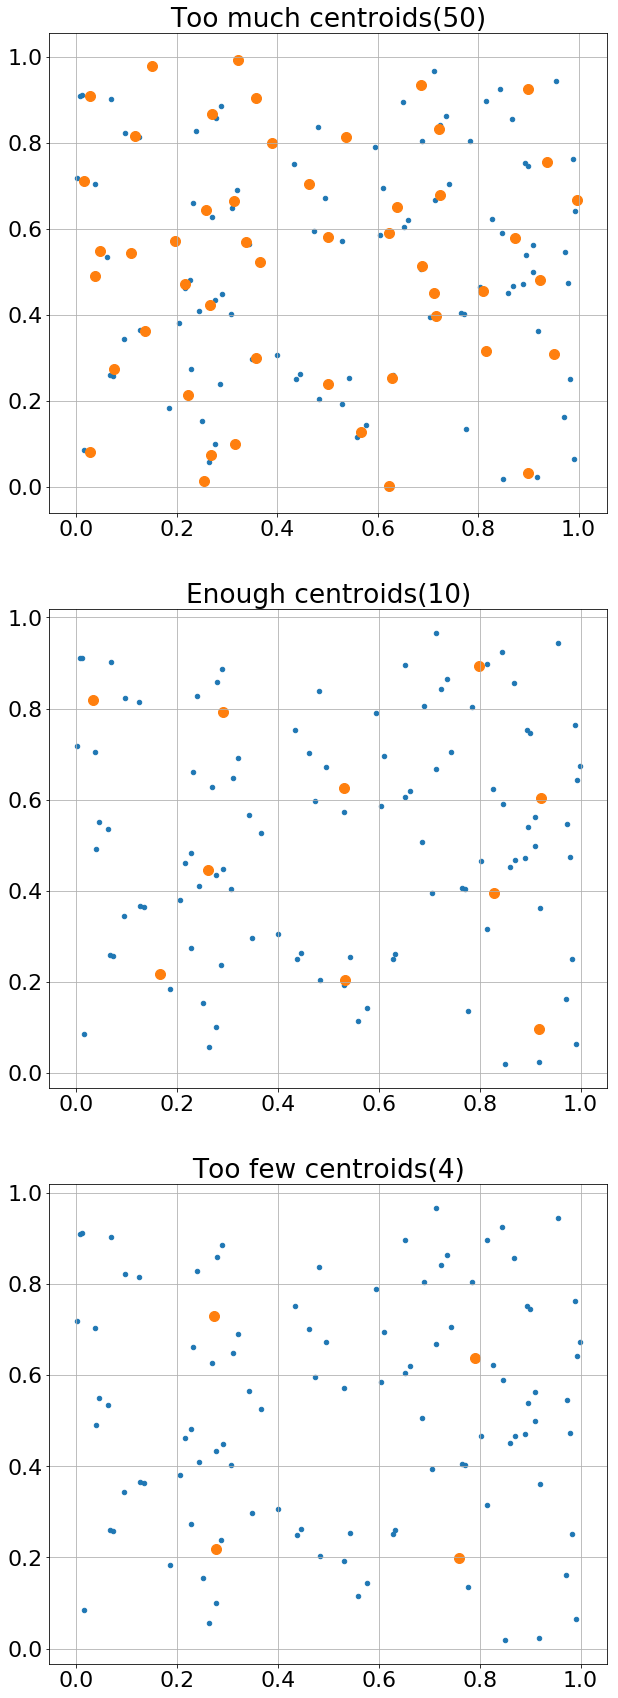

In [282]:
plt.rcParams['figure.figsize'] = [10, 30] #figure size
fig, axs = plt.subplots(3)
axs[0].set_title("Too much centroids(50)")
axs[0].scatter(train_inputs[:, 0], train_inputs[:, 1], s=20)
axs[0].scatter(adjusted_too_much_centers[:, 0], adjusted_too_much_centers[:, 1], s=100)
axs[0].grid()

axs[1].set_title("Enough centroids(10)")
axs[1].scatter(train_inputs[:, 0], train_inputs[:, 1], s=20)
axs[1].scatter(adjusted_enough_centers[:, 0], adjusted_enough_centers[:, 1], s=100)
axs[1].grid()

axs[2].set_title("Too few centroids(4)")
axs[2].scatter(train_inputs[:, 0], train_inputs[:, 1], s=20)
axs[2].scatter(adjusted_not_enough_centers[:, 0], adjusted_not_enough_centers[:, 1], s=100)
axs[2].grid()

plt.show()

With fewer units, we need to increase the width(variance), so the units can cover more points. When we have a lot of units, the performance is better, however, the test error increases in a bigger portion of the training error, what indicates overfitting the noisy data. 

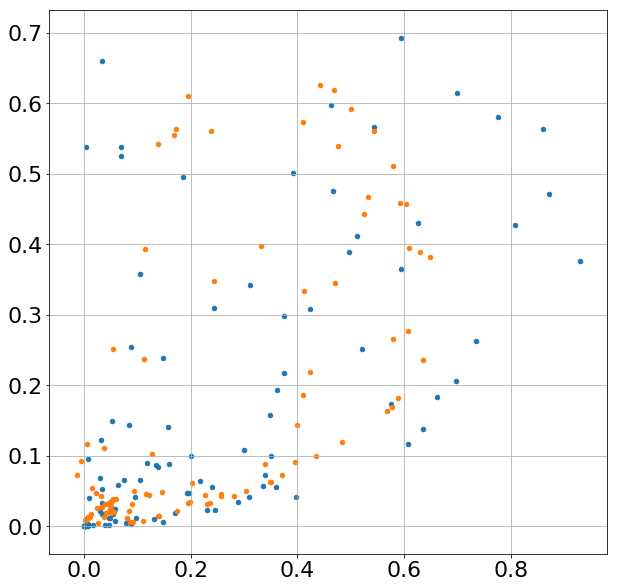

In [265]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(test_outputs[:, 0], test_outputs[:, 1], s=20)
plt.scatter(results_test_enough[:, 0], results_test_enough[:, 1], s=20)
plt.grid()
plt.show()